<a href="https://colab.research.google.com/github/Molten-Ice/VesuviusChallenge/blob/dev/Hercules.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# VesuviusChallenge - Deciphering Ancient Papyrus Scrolls

# Helper Functions

## Download and load data from Kaggle

In [1]:
### Download data from kaggle, and store a segment of it in google drive

# import json
# import zipfile
# kaggle_apikey = {"username":"jamesdavey","key":"a8975caa44cfa08d6f2164f2d5977b6e"}

# if not os.path.exists('/root/.kaggle'): os.mkdir('/root/.kaggle')
# with open('/root/.kaggle/kaggle.json', 'w') as f:
#     json.dump(kaggle_apikey, f)

# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c 'vesuvius-challenge-ink-detection' --force
# # #1% 131M/20.6G [00:06<17:23, 21.1MB/s]

# with zipfile.ZipFile("/content/vesuvius-challenge-ink-detection.zip","r") as zip_ref:
#     zip_ref.extractall("kaggledata")

# !zip -r -j /content/ink1.zip /content/content/kaggledata/train/1

# # upload zip to google drive
# from google.colab import drive
# drive.mount('/content/gdrive')
# !cp /content/ink1.zip /content/gdrive/MyDrive/AIData/vesuvius1.zip

In [2]:
%%time
## Retrieve data(zip) from google drive, unzip and store locally
from google.colab import drive
drive.mount('/content/gdrive')
!cp /content/gdrive/MyDrive/AIData/vesuvius1.zip /content/vesuvius1.zip 

import zipfile
with zipfile.ZipFile("vesuvius1.zip","r") as zip_ref:
    zip_ref.extractall("train_1")
drive.flush_and_unmount()

Mounted at /content/gdrive
CPU times: user 32.6 s, sys: 5.66 s, total: 38.2 s
Wall time: 1min 16s


## Imports 



In [3]:
import torch
import torch.nn as nn
import numpy as np
import PIL
import matplotlib.pyplot as plt
import matplotlib
from tqdm import tqdm
from pathlib import Path
import os
import time
import torchvision
import copy

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"on device: {device}")

on device: cuda


In [4]:
#Delete when using kaggle
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

[INFO] Couldn't find torchinfo... installing it.


## Loading mask, labels & create image_stack

In [5]:
def load_mask_label(mask_filepath=None, label_filepath=None, display = True):
  mask = False if mask_filepath is None else torch.from_numpy(np.array(PIL.Image.open(mask_filepath).convert('1')))
  label = False if label_filepath is None else torch.from_numpy(np.array(PIL.Image.open(label_filepath))).float().to(device)
  if display:
    if label_filepath is None:
      plt.imshow(mask, cmap = 'gray')
    else:
      fig, (ax1, ax2) = plt.subplots(1, 2)
      ax1.imshow(mask, cmap = 'gray')
      ax2.imshow(label.cpu(), cmap = 'gray')
      plt.show()
  return mask, label

In [6]:
def generate_image_stack(tif_filepaths, Z_START, Z_DIM, display = True):
  layers_to_use = tif_filepaths[Z_START:Z_START+Z_DIM]
  image_stack = [np.array(PIL.Image.open(filepath), dtype=np.float32)/65535.0 for filepath in tqdm(layers_to_use)]
  if display:
    fig, axes = plt.subplots(1, len(image_stack), figsize=(15, 3))
    for image, ax in zip(image_stack, axes):
        ax.imshow(np.array(PIL.Image.fromarray(image).resize((image.shape[1]//20, image.shape[0]//20)), dtype=np.float32), cmap='gray')
        ax.set_xticks([]); ax.set_yticks([])
    fig.tight_layout()
    plt.show()
  image_stack = torch.stack([torch.from_numpy(image) for image in image_stack], dim=0).to(device)
  print(f"image_stack shape: {image_stack.shape}")
  return image_stack

## Creating pixels




In [7]:
# Takes in a mask, and outputs the set of pixels (x,y) in intersection of that mask with a rectangle
# Also outputs the set intersection of that mask with the exterior of the rectangle

# Generate pixels for test
def get_pixels(mask, rect, BUFFER, stride = 0):
  """
  if not sparse: returns (inside_rect, outside rect) within the mask and outside the buffer
  
  """

  max_h,max_w = mask.shape # Height and width of mask
  x, y, w, h = rect

  # Create a Boolean array of the same shape as the bitmask, initially all True
  not_border = np.zeros(mask.shape, dtype=bool)
  not_border[BUFFER:max_h-BUFFER, BUFFER:max_w-BUFFER] = True
  arr_mask = np.array(mask) * not_border

  inside_rect = np.zeros(mask.shape, dtype=bool)
  # Sets all indexes with inside_rect array to true
  inside_rect[y:y+h+1, x:x+w+1] = True
  inside_rect = inside_rect*arr_mask

  if stride != 0:
    assert stride % 2 == 1, "sparse has to be an odd number!"
    sparse_mask = np.zeros(mask.shape, dtype=bool)
    sparse_mask[::stride, ::stride] = True
    sparse_mask = sparse_mask*arr_mask

        #sparse inside, full set
    return np.argwhere(inside_rect*sparse_mask), np.argwhere(sparse_mask)    


  #do not want a data leak into train dataset so leave a BUFFER zone around
  x2, y2, w2, h2 = (rect[0]-BUFFER,#x
                 rect[1]-BUFFER,#y
                 rect[2]+2*BUFFER,#w
                 rect[3]+2*BUFFER)#h

  outside_rect = arr_mask #np.ones(mask.shape, dtype=bool) * arr_mask
  # Set the pixels within the inside_rect to False
  outside_rect[y2:y2+h2+1, x2:x2+w2+1] = False

  return np.argwhere(inside_rect), np.argwhere(outside_rect)

# inside_rect, outside_rect = get_pixels(mask, evaluation_rectangle, dist_from_centre)
# inside_pixels_sparse, all_pixels_sparse = get_pixels(mask, evaluation_rectangle, dist_from_centre, sparse = 3)

In [8]:
class SubvolumeDataset(torch.utils.data.Dataset):
    def __init__(self, image_stack, label, pixels, dist_from_centre):
        self.image_stack = image_stack
        self.label = label
        self.pixels = pixels
        self.dist = dist_from_centre
    def __len__(self):
        return len(self.pixels)
    def __getitem__(self, index):
        y, x = self.pixels[index]
        subvolume = self.image_stack[:, y-self.dist:y+self.dist, x-self.dist:x+self.dist].unsqueeze(dim=0)
        ink_label = self.label[y, x].unsqueeze(dim=0)
        return subvolume, ink_label

In [9]:
def create_train_eval_dataloaders(image_stack, mask, label, evaluation_rectangle, dist_from_centre, batch_size, print_out = True):
  evaluation_pixels, train_pixels = get_pixels(mask, evaluation_rectangle, dist_from_centre)

  train_dataset = SubvolumeDataset(image_stack, label, train_pixels, dist_from_centre)
  evaluation_dataset = SubvolumeDataset(image_stack, label, evaluation_pixels, dist_from_centre)

  train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  eval_dataloader = torch.utils.data.DataLoader(evaluation_dataset, batch_size=batch_size, shuffle=False)

  if print_out:
    print(f"Train elements: {len(train_dataset)} | Evaluation elements: {len(evaluation_dataset)}")
    print(f"Length of train_dataloader: {len(train_dataloader)} batches of size {batch_size}")
    print(f"Length of eval_dataloader: {len(eval_dataloader)} batches of size {batch_size}")
    xb, yb = next(iter(train_dataloader))
    print(f"xb.shape: {xb.shape} | yb.shape: {yb.shape}")

  return train_dataloader, eval_dataloader

## Train Loop

In [10]:
def train_loop(model,
               training_steps,
               eval_interval,
               train_dataloader,
               eval_dataloader,
               learning_rate = 0.03,
               optimizer=None, 
               scheduler=None):
  
  loss_fn = nn.BCELoss()
  if optimizer is None:
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
  if scheduler is None:
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate, total_steps=training_steps)

  model.train()
  for i, (subvolumes, inklabels) in tqdm(enumerate(train_dataloader), total=training_steps):
      if i >= training_steps:
          break
      subvolumes, inklabels = subvolumes.to(device), inklabels.to(device)
      
      outputs = model(subvolumes)
      loss = loss_fn(outputs, inklabels)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      scheduler.step()

      if i % eval_interval == 0:
        train_loss = evaluate(model, train_dataloader)
        test_loss = evaluate(model, eval_dataloader)
        time_taken = (train_loss['time']+test_loss['time'])/2
        print(f"Train Loss: {train_loss['loss']} | Test Loss: {test_loss['loss']} | Time taken: {time_taken:.3f}")

## Evaluate

In [11]:
def evaluate(model, data_loader, eval_iterations = 50):
  loss_fn = nn.BCELoss()
  t = time.time()
  model.eval()
  with torch.inference_mode():
    losses = []
    for i, (xb, yb) in enumerate(data_loader):
      if i >= eval_iterations:
          break
      xb, yb = xb.to(device), yb.to(device)
      outputs = model(xb)
      loss = loss_fn(outputs, yb)
      losses.append(loss.item())
      
  model.train()
  return {'loss': round(np.array(losses).mean(), 5),
          'time': round(time.time()-t, 3)}

## Display predictions

In [12]:
def find_dice_coefficient(pred_mask_raw, labels, threshold):
  # img_ink_mask are the predictions here
  pred_mask = torch.Tensor(pred_mask_raw).gt(threshold)
  dice_coefficient = 2*((labels==1)*(labels == pred_mask)).sum()/((pred_mask==1).sum()+(labels==1).sum())
  return round(dice_coefficient.item(), 5)

def generate_predictions(model, evaluation_rectangle, only_rectangle=True, stride = 0):
  inside_pixels_sparse, all_pixels_sparse = get_pixels(mask, evaluation_rectangle, dist_from_centre, stride = stride)
  inside_dataset = SubvolumeDataset(image_stack, label, inside_pixels_sparse, dist_from_centre)
  all_dataset = SubvolumeDataset(image_stack, label, all_pixels_sparse, dist_from_centre)
  inside_dataloader = torch.utils.data.DataLoader(inside_dataset, batch_size=batch_size, shuffle=False)
  all_dataloader = torch.utils.data.DataLoader(all_dataset, batch_size=batch_size, shuffle=False)

  if only_rectangle:
    dataloader, pixels = inside_dataloader, inside_pixels_sparse
  else:
    dataloader, pixels = all_dataloader, all_pixels_sparse

  output = torch.zeros_like(label).float()
  model.eval()
  with torch.no_grad():
      for i, (subvolumes, _) in enumerate(tqdm(dataloader)):
          for j, value in enumerate(model(subvolumes.to(device))):
            y, x = pixels[i*batch_size+j]
            output[y, x] = value

  output = output.cpu().numpy()

  #fill in pixels
  if stride != 0:
    # output = temp[3600:3610, 1200:1210].copy()
    spacing = stride//2
    hor_filled = np.zeros(output.shape)
    for i in range(2*spacing):# duplicating horizontally
      hor_filled[:, spacing:-spacing] += output[:, i:-2*spacing+i].copy()
    hor_filled[:, spacing:-spacing] += output[:, 2*spacing:].copy()

    filled = np.zeros(hor_filled.shape)
    for i in range(2*spacing):# duplicating vertically
      filled[spacing:-spacing] += hor_filled[i:-2*spacing+i].copy()
    filled[spacing:-spacing] += hor_filled[2*spacing:].copy()

    # output = filled[3600:3610, 1200:1210]
    # for r in torch.tensor(output): print([round(x.item(),3) for x in r]) 
    return torch.Tensor(filled)

def display_predictions(model, evaluation_rectangle, only_rectangle=False, threshold = 0.4, stride = 0, output=None):
  if output is None: output = generate_predictions(model, evaluation_rectangle, only_rectangle=only_rectangle, stride = stride)
  predictions, ground_truth = output, label.cpu()

  x, y, w, h = evaluation_rectangle
  if not only_rectangle:
    print(f"Sørensen–Dice coefficient for full data: {find_dice_coefficient(predictions, ground_truth, threshold = threshold)}")
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(predictions, cmap='gray')
    ax2.imshow(ground_truth, cmap='gray')
    # patch = matplotlib.patches.Rectangle((evaluation_rectangle[0], evaluation_rectangle[1]), evaluation_rectangle[2], evaluation_rectangle[3], linewidth=2, edgecolor='b', facecolor='none')
    # ax1.add_patch(patch)
    # ax2.add_patch(patch)
    plt.show()

  evaluation_segment, label_segment = predictions[y:y+h+1, x:x+w+1], ground_truth[y:y+h+1, x:x+w+1]
  print(f"Sørensen–Dice coefficient for evaluation data: {find_dice_coefficient(evaluation_segment, label_segment, threshold = threshold)}")
  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(evaluation_segment, cmap='gray')
  ax2.imshow(label_segment, cmap='gray')
  plt.show()

  fig, (ax1, ax2) = plt.subplots(1, 2)
  ax1.imshow(evaluation_segment.gt(threshold), cmap='gray')
  ax2.imshow(label_segment, cmap='gray')
  plt.show()

# Models

## Apollo



In [13]:
import collections
class Apollo(nn.Module):
  
  def __init__(self):
    super().__init__()
    conv3d = nn.Sequential(
      nn.Conv3d(1, 16, 3, 1, 1), nn.MaxPool3d(2, 2),
      nn.Conv3d(16, 32, 3, 1, 1), nn.MaxPool3d(2, 2),
      nn.Conv3d(32, 64, 3, 1, 1), nn.MaxPool3d(2, 2)) #[32, 1, 10, 64, 64] -> [32, 64, 1, 8, 8]
    head = nn.Sequential(
            nn.Flatten(start_dim=1),
            nn.Linear(4096, 128), nn.ReLU(),
            nn.Linear(128, 1), nn.Sigmoid())
    self.layers = nn.Sequential(
        collections.OrderedDict([
            ('Conv3dBlock', conv3d), 
            ('head', head)]))

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return self.layers(x)

# apollo = Apollo().to(device)
#     print(name)
# apollo

## Hercules

VisionTransformer [source code](https://github.com/pytorch/vision/blob/main/torchvision/models/vision_transformer.py)

In [14]:
num_layers = 1
n_heads = 6
d_model = 384

#split into 8x8 patches grid (with 64 features for each patch)
class CustomViT(torchvision.models.vision_transformer.VisionTransformer):
  def __init__(self, **kwargs):
    super().__init__(**kwargs)
    self.projection = nn.Linear(64, 384)

  def _process_input(self, x: torch.Tensor) -> torch.Tensor:
    #x.shape: (32, 64, 1, 8, 8)
    x = x.view(-1, 64, 64) # (b c t) (32 64 64)
    x = x.permute(0, 2, 1) # (b t c)
    return self.projection(x)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    return torch.sigmoid(super().forward(x))

class HerculesModel(nn.Module):
  def __init__(self, apollo):
    super().__init__()
    
    #freeze self.Conv3dBlock layers after instantiation

    vision_transformer = CustomViT(
        image_size=64,
        patch_size=8,
        num_layers=num_layers,
        num_heads=n_heads,
        hidden_dim=d_model,
        mlp_dim=4*d_model,
        # representation_size=50,
        num_classes=1).to(device)

    self.layers = nn.Sequential(
        collections.OrderedDict([
            ('apollo_conv3d', copy.deepcopy(apollo.layers.Conv3dBlock)),
            ('vision_transformer', vision_transformer)
        ]))
    
    for param in self.layers.apollo_conv3d.parameters():
      param.requires_grad = False


  def forward(self, x: torch.Tensor, targets = None) -> torch.Tensor:
    return self.layers(x)

# hercules_temp = HerculesModel(Apollo()).to(device)
# summary(hercules_temp, input_size=[32, 1, 10, 64, 64], col_names =['input_size', 'output_size', 'num_params', 'trainable'])

In [15]:
# del hercules_temp

#Training

In [16]:
### Hyperparameters
Z_START = 27 # First slice in the z direction to use
Z_DIM = 10   # Number of slices in the z direction
dist_from_centre = 32
batch_size = 32

training_steps = 30000
eval_interval = 3000
learning_rate = 3e-2

In [17]:
# root_filepath = '/kaggle/input/vesuvius-challenge-ink-detection/train/1/'
root_filepath = '/content/train_1/'
tif_filepaths = [root_filepath+ x for x in sorted(os.listdir(root_filepath))[:-4]]
print(len(tif_filepaths), tif_filepaths[:5])

65 ['/content/train_1/00.tif', '/content/train_1/01.tif', '/content/train_1/02.tif', '/content/train_1/03.tif', '/content/train_1/04.tif']


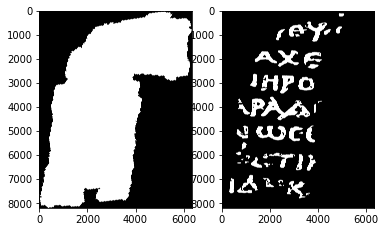

100%|██████████| 10/10 [00:02<00:00,  3.51it/s]


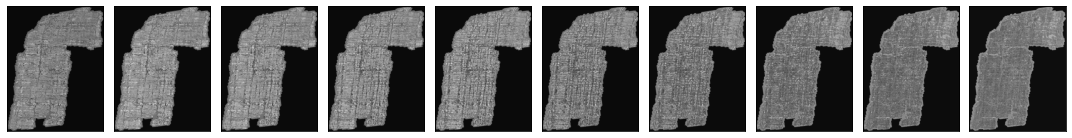

image_stack shape: torch.Size([10, 8181, 6330])


In [18]:
mask, label = load_mask_label(root_filepath+"mask.png", root_filepath+"inklabels.png")
image_stack = generate_image_stack(tif_filepaths, Z_START, Z_DIM)

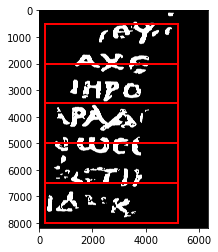

In [19]:
# rect = (1100, 3500, 700, 950) # (x, y, w, h)

#(3500, 500, 100, 100),
#(1100, 3500, 700, 950),

rectangles = [(200, 500, 5000, 1500),
              (200, 2000, 5000, 1500),
              (200, 3500, 5000, 1500),
              (200, 5000, 5000, 1500),
              (200, 6500, 5000, 1500)]
fig, ax = plt.subplots()
ax.imshow(label.cpu(), cmap='gray')
for rect in rectangles:
  patch = matplotlib.patches.Rectangle((rect[0], rect[1]), rect[2], rect[3], linewidth=2, edgecolor='r', facecolor='none')
  ax.add_patch(patch)
plt.show()

In [ ]:
stop

----------------------------------------------------------------------------------------------------
Testing out rectangle: (200, 500, 5000, 1500)
Train elements: 23903948 | Evaluation elements: 4989667
Length of train_dataloader: 746999 batches of size 32
Length of eval_dataloader: 155928 batches of size 32
xb.shape: torch.Size([32, 1, 10, 64, 64]) | yb.shape: torch.Size([32, 1])


  0%|          | 28/30000 [00:13<2:49:38,  2.94it/s] 

Train Loss: 0.70276 | Test Loss: 0.70024 | Time taken: 1.332


 10%|█         | 3054/30000 [00:27<11:02, 40.66it/s]

Train Loss: 0.43881 | Test Loss: 0.51586 | Time taken: 1.418


 20%|██        | 6040/30000 [00:41<09:08, 43.69it/s]

Train Loss: 0.40558 | Test Loss: 0.43418 | Time taken: 1.333


 30%|███       | 9034/30000 [00:54<08:32, 40.93it/s]

Train Loss: 0.4074 | Test Loss: 0.6599 | Time taken: 1.336


 40%|████      | 12038/30000 [01:08<06:55, 43.21it/s]

Train Loss: 0.41611 | Test Loss: 0.49634 | Time taken: 1.339


 50%|█████     | 15038/30000 [01:21<05:57, 41.90it/s]

Train Loss: 0.40191 | Test Loss: 0.50735 | Time taken: 1.333


 60%|██████    | 18044/30000 [01:35<04:39, 42.80it/s]

Train Loss: 0.36908 | Test Loss: 0.57852 | Time taken: 1.333


 70%|███████   | 21039/30000 [01:48<03:31, 42.32it/s]

Train Loss: 0.33781 | Test Loss: 0.45925 | Time taken: 1.341


 80%|████████  | 24042/30000 [02:02<02:19, 42.84it/s]

Train Loss: 0.27188 | Test Loss: 0.46752 | Time taken: 1.336


 90%|█████████ | 27051/30000 [02:15<01:08, 42.91it/s]

Train Loss: 0.25584 | Test Loss: 0.48145 | Time taken: 1.343


100%|██████████| 30000/30000 [02:26<00:00, 205.17it/s]


Apollo train loss: 0.2404
Apollo test loss: 0.32273


100%|██████████| 18583/18583 [00:41<00:00, 443.27it/s]


Sørensen–Dice coefficient for full data: 0.65068


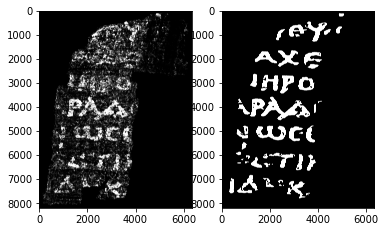

Sørensen–Dice coefficient for evaluation data: 0.48959


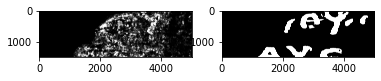

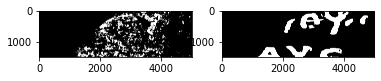

  0%|          | 20/30000 [00:05<1:39:25,  5.03it/s]

Train Loss: 0.66912 | Test Loss: 0.67384 | Time taken: 1.601


 10%|█         | 3018/30000 [00:25<22:56, 19.61it/s] 

Train Loss: 0.31583 | Test Loss: 0.40035 | Time taken: 1.390


 20%|██        | 6034/30000 [00:44<14:46, 27.03it/s]

Train Loss: 0.29822 | Test Loss: 0.4982 | Time taken: 1.396


 30%|███       | 9033/30000 [01:04<13:50, 25.24it/s]

Train Loss: 0.2831 | Test Loss: 0.48312 | Time taken: 1.467


 40%|████      | 12031/30000 [01:24<11:05, 27.00it/s]

Train Loss: 0.27637 | Test Loss: 0.39688 | Time taken: 1.375


 50%|█████     | 15021/30000 [01:43<09:24, 26.54it/s]

Train Loss: 0.2723 | Test Loss: 0.48589 | Time taken: 1.383


 60%|██████    | 18021/30000 [02:03<07:30, 26.59it/s]

Train Loss: 0.25195 | Test Loss: 0.48245 | Time taken: 1.383


 70%|███████   | 21025/30000 [02:22<05:27, 27.40it/s]

Train Loss: 0.24179 | Test Loss: 0.51361 | Time taken: 1.393


 80%|████████  | 24036/30000 [02:42<03:47, 26.23it/s]

Train Loss: 0.21755 | Test Loss: 0.32924 | Time taken: 1.393


 90%|█████████ | 27028/30000 [03:01<01:51, 26.72it/s]

Train Loss: 0.21931 | Test Loss: 0.48675 | Time taken: 1.399


100%|██████████| 30000/30000 [03:18<00:00, 151.12it/s]


Hercules train loss: 0.21008
Hercules test loss: 0.41769


100%|██████████| 18583/18583 [00:56<00:00, 326.37it/s]


Sørensen–Dice coefficient for full data: 0.69651


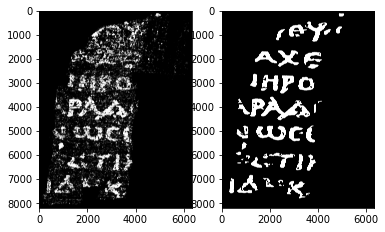

Sørensen–Dice coefficient for evaluation data: 0.4638


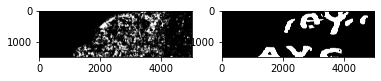

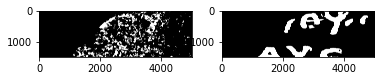

Complete time taken: 470.8231 seconds
----------------------------------------------------------------------------------------------------
Testing out rectangle: (200, 2000, 5000, 1500)
Train elements: 23504817 | Evaluation elements: 5366253
Length of train_dataloader: 734526 batches of size 32
Length of eval_dataloader: 167696 batches of size 32
xb.shape: torch.Size([32, 1, 10, 64, 64]) | yb.shape: torch.Size([32, 1])


  0%|          | 29/30000 [00:04<1:00:57,  8.19it/s]

Train Loss: 0.66636 | Test Loss: 0.70297 | Time taken: 1.329


 10%|█         | 3039/30000 [00:18<10:33, 42.53it/s]

Train Loss: 0.41084 | Test Loss: 0.81343 | Time taken: 1.330


 20%|██        | 6045/30000 [00:32<09:22, 42.62it/s]

Train Loss: 0.38282 | Test Loss: 0.96433 | Time taken: 1.332


 30%|███       | 9030/30000 [00:45<08:10, 42.73it/s]

Train Loss: 0.34587 | Test Loss: 0.84646 | Time taken: 1.348


 40%|████      | 12034/30000 [00:59<07:15, 41.28it/s]

Train Loss: 0.33102 | Test Loss: 0.98815 | Time taken: 1.353


 50%|█████     | 15034/30000 [01:13<05:52, 42.42it/s]

Train Loss: 0.31319 | Test Loss: 0.79884 | Time taken: 1.352


 60%|██████    | 18052/30000 [01:26<04:43, 42.10it/s]

Train Loss: 0.34305 | Test Loss: 1.01619 | Time taken: 1.339


 70%|███████   | 21029/30000 [01:40<03:29, 42.90it/s]

Train Loss: 0.28456 | Test Loss: 1.07455 | Time taken: 1.323


 80%|████████  | 24050/30000 [01:54<02:24, 41.32it/s]

Train Loss: 0.29413 | Test Loss: 0.95267 | Time taken: 1.353


 90%|█████████ | 27030/30000 [02:07<01:10, 41.97it/s]

Train Loss: 0.23402 | Test Loss: 0.79227 | Time taken: 1.343


100%|██████████| 30000/30000 [02:18<00:00, 216.61it/s]


Apollo train loss: 0.22591
Apollo test loss: 0.60618


100%|██████████| 18583/18583 [00:41<00:00, 442.53it/s]


Sørensen–Dice coefficient for full data: 0.64357


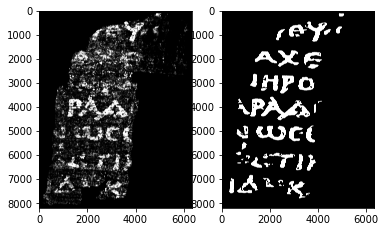

Sørensen–Dice coefficient for evaluation data: 0.35216


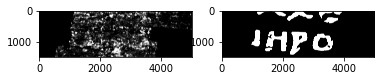

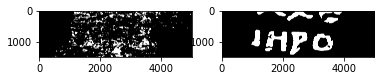

  0%|          | 19/30000 [00:05<1:35:36,  5.23it/s]

Train Loss: 0.67545 | Test Loss: 0.69787 | Time taken: 1.375


 10%|█         | 3023/30000 [00:25<16:29, 27.25it/s]

Train Loss: 0.48949 | Test Loss: 1.35831 | Time taken: 1.359


 20%|██        | 6032/30000 [00:44<14:45, 27.06it/s]

Train Loss: 0.30184 | Test Loss: 0.6834 | Time taken: 1.364


 30%|███       | 9028/30000 [01:04<13:05, 26.69it/s]

Train Loss: 0.2866 | Test Loss: 0.82519 | Time taken: 1.382


 40%|████      | 12035/30000 [01:23<11:13, 26.67it/s]

Train Loss: 0.25404 | Test Loss: 0.74272 | Time taken: 1.399


 50%|█████     | 15032/30000 [01:43<09:22, 26.59it/s]

Train Loss: 0.23932 | Test Loss: 0.77988 | Time taken: 1.379


 60%|██████    | 18036/30000 [02:03<07:45, 25.71it/s]

Train Loss: 0.23287 | Test Loss: 0.68208 | Time taken: 1.472


 70%|███████   | 21028/30000 [02:22<05:42, 26.16it/s]

Train Loss: 0.25164 | Test Loss: 0.92517 | Time taken: 1.370


 80%|████████  | 24028/30000 [02:42<03:53, 25.59it/s]

Train Loss: 0.19497 | Test Loss: 0.83151 | Time taken: 1.472


 90%|█████████ | 27025/30000 [03:02<01:49, 27.06it/s]

Train Loss: 0.19391 | Test Loss: 0.88481 | Time taken: 1.366


100%|██████████| 30000/30000 [03:18<00:00, 150.80it/s]


Hercules train loss: 0.18245
Hercules test loss: 0.70756


100%|██████████| 18583/18583 [00:57<00:00, 324.57it/s]


Sørensen–Dice coefficient for full data: 0.70486


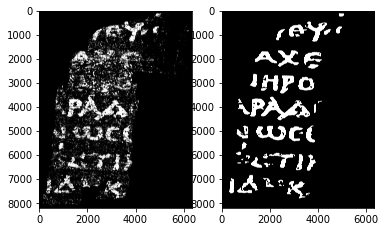

Sørensen–Dice coefficient for evaluation data: 0.39889


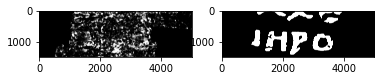

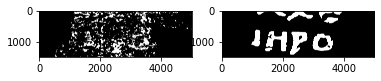

Complete time taken: 463.3587 seconds
----------------------------------------------------------------------------------------------------
Testing out rectangle: (200, 3500, 5000, 1500)
Train elements: 23536731 | Evaluation elements: 5374869
Length of train_dataloader: 735523 batches of size 32
Length of eval_dataloader: 167965 batches of size 32
xb.shape: torch.Size([32, 1, 10, 64, 64]) | yb.shape: torch.Size([32, 1])


  0%|          | 29/30000 [00:04<1:00:39,  8.23it/s]

Train Loss: 0.68063 | Test Loss: 0.67757 | Time taken: 1.321


 10%|█         | 3035/30000 [00:18<10:40, 42.12it/s]

Train Loss: 0.4021 | Test Loss: 0.18179 | Time taken: 1.343


 20%|██        | 6041/30000 [00:32<09:31, 41.93it/s]

Train Loss: 0.4154 | Test Loss: 0.10458 | Time taken: 1.325


 30%|███       | 9052/30000 [00:46<08:12, 42.49it/s]

Train Loss: 0.3634 | Test Loss: 0.17839 | Time taken: 1.329


 40%|████      | 12050/30000 [00:59<07:01, 42.58it/s]

Train Loss: 0.35303 | Test Loss: 0.19259 | Time taken: 1.332


 50%|█████     | 15055/30000 [01:13<05:52, 42.39it/s]

Train Loss: 0.35557 | Test Loss: 0.21268 | Time taken: 1.333


 60%|██████    | 18027/30000 [01:26<04:52, 40.94it/s]

Train Loss: 0.32674 | Test Loss: 0.26379 | Time taken: 1.332


 70%|███████   | 21047/30000 [01:40<03:34, 41.72it/s]

Train Loss: 0.32831 | Test Loss: 0.17135 | Time taken: 1.351


 80%|████████  | 24044/30000 [01:54<02:23, 41.55it/s]

Train Loss: 0.30073 | Test Loss: 0.19284 | Time taken: 1.329


 90%|█████████ | 27028/30000 [02:07<01:33, 31.65it/s] 

Train Loss: 0.24574 | Test Loss: 0.19698 | Time taken: 1.327


100%|██████████| 30000/30000 [02:18<00:00, 216.44it/s]


Apollo train loss: 0.24712
Apollo test loss: 0.26283


100%|██████████| 18583/18583 [00:42<00:00, 439.65it/s]


Sørensen–Dice coefficient for full data: 0.63972


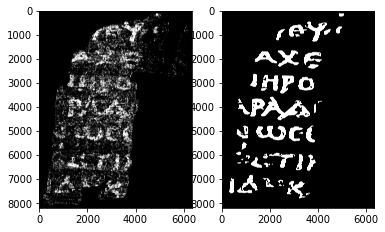

Sørensen–Dice coefficient for evaluation data: 0.55437


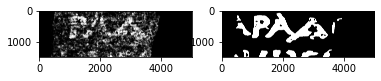

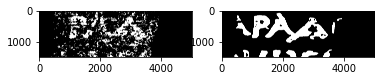

  0%|          | 19/30000 [00:05<1:34:51,  5.27it/s]

Train Loss: 0.67335 | Test Loss: 0.66382 | Time taken: 1.365


 10%|█         | 3032/30000 [00:25<17:01, 26.41it/s]

Train Loss: 0.3059 | Test Loss: 0.20031 | Time taken: 1.371


 20%|██        | 6034/30000 [00:44<14:58, 26.67it/s]

Train Loss: 0.27403 | Test Loss: 0.08238 | Time taken: 1.379


 30%|███       | 9021/30000 [01:04<13:14, 26.39it/s]

Train Loss: 0.25937 | Test Loss: 0.28469 | Time taken: 1.380


 40%|████      | 12025/30000 [01:24<11:01, 27.18it/s]

Train Loss: 0.26403 | Test Loss: 0.18888 | Time taken: 1.370


 50%|█████     | 15026/30000 [01:43<09:20, 26.72it/s]

Train Loss: 0.26857 | Test Loss: 0.11626 | Time taken: 1.377


 60%|██████    | 18034/30000 [02:03<07:25, 26.88it/s]

Train Loss: 0.22945 | Test Loss: 0.23042 | Time taken: 1.372


 70%|███████   | 21036/30000 [02:23<05:34, 26.82it/s]

Train Loss: 0.22992 | Test Loss: 0.21863 | Time taken: 1.355


 80%|████████  | 24019/30000 [02:42<03:42, 26.83it/s]

Train Loss: 0.20403 | Test Loss: 0.29925 | Time taken: 1.363


 90%|█████████ | 27036/30000 [03:02<01:50, 26.73it/s]

Train Loss: 0.20019 | Test Loss: 0.26527 | Time taken: 1.379


100%|██████████| 30000/30000 [03:19<00:00, 150.52it/s]


Hercules train loss: 0.1948
Hercules test loss: 0.3186


100%|██████████| 18583/18583 [00:57<00:00, 324.25it/s]


Sørensen–Dice coefficient for full data: 0.69932


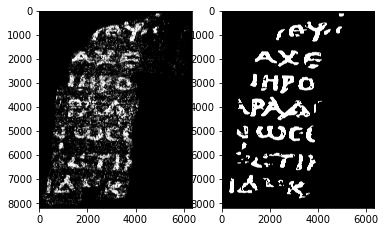

Sørensen–Dice coefficient for evaluation data: 0.55463


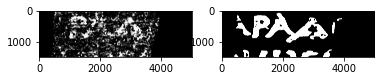

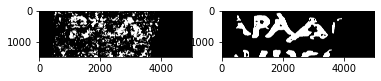

Complete time taken: 464.4243 seconds
----------------------------------------------------------------------------------------------------
Testing out rectangle: (200, 5000, 5000, 1500)
Train elements: 23628354 | Evaluation elements: 5278866
Length of train_dataloader: 738387 batches of size 32
Length of eval_dataloader: 164965 batches of size 32
xb.shape: torch.Size([32, 1, 10, 64, 64]) | yb.shape: torch.Size([32, 1])


  0%|          | 29/30000 [00:04<1:01:14,  8.16it/s]

Train Loss: 0.6755 | Test Loss: 0.68986 | Time taken: 1.341


 10%|█         | 3041/30000 [00:18<10:40, 42.11it/s]

Train Loss: 0.39549 | Test Loss: 0.87322 | Time taken: 1.340


 20%|██        | 6029/30000 [00:32<09:22, 42.63it/s]

Train Loss: 0.39822 | Test Loss: 1.03766 | Time taken: 1.337


 30%|███       | 9034/30000 [00:46<08:21, 41.83it/s]

Train Loss: 0.3877 | Test Loss: 1.23978 | Time taken: 1.331


 40%|████      | 12039/30000 [00:59<07:07, 41.99it/s]

Train Loss: 0.36792 | Test Loss: 0.8382 | Time taken: 1.343


 50%|█████     | 15039/30000 [01:13<05:58, 41.72it/s]

Train Loss: 0.35988 | Test Loss: 0.81779 | Time taken: 1.339


 60%|██████    | 18047/30000 [01:27<04:40, 42.54it/s]

Train Loss: 0.31394 | Test Loss: 0.91772 | Time taken: 1.327


 70%|███████   | 21035/30000 [01:40<03:28, 42.97it/s]

Train Loss: 0.35442 | Test Loss: 0.79386 | Time taken: 1.325


 80%|████████  | 24044/30000 [01:54<02:20, 42.35it/s]

Train Loss: 0.30334 | Test Loss: 0.75547 | Time taken: 1.331


 90%|█████████ | 27050/30000 [02:07<01:09, 42.23it/s]

Train Loss: 0.2511 | Test Loss: 0.90871 | Time taken: 1.351


100%|██████████| 30000/30000 [02:18<00:00, 216.45it/s]


Apollo train loss: 0.2448
Apollo test loss: 0.65569


100%|██████████| 18583/18583 [00:42<00:00, 438.75it/s]


Sørensen–Dice coefficient for full data: 0.64932


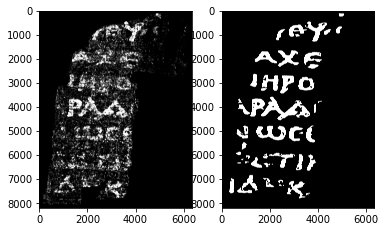

Sørensen–Dice coefficient for evaluation data: 0.49138


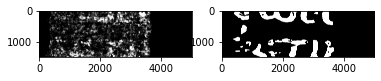

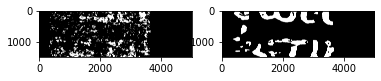

  0%|          | 19/30000 [00:05<1:35:08,  5.25it/s]

Train Loss: 0.66673 | Test Loss: 0.68805 | Time taken: 1.370


 10%|█         | 3025/30000 [00:25<16:42, 26.91it/s]

Train Loss: 0.30727 | Test Loss: 0.75483 | Time taken: 1.365


 20%|██        | 6030/30000 [00:45<15:03, 26.52it/s]

Train Loss: 0.2616 | Test Loss: 0.77547 | Time taken: 1.383


 30%|███       | 9032/30000 [01:04<13:04, 26.74it/s]

Train Loss: 0.29986 | Test Loss: 1.05992 | Time taken: 1.396


 40%|████      | 12025/30000 [01:24<11:02, 27.12it/s]

Train Loss: 0.26616 | Test Loss: 0.94604 | Time taken: 1.355


 50%|█████     | 15026/30000 [01:44<09:04, 27.50it/s]

Train Loss: 0.2523 | Test Loss: 0.72524 | Time taken: 1.362


 60%|██████    | 18024/30000 [02:04<07:24, 26.97it/s]

Train Loss: 0.24702 | Test Loss: 0.85474 | Time taken: 1.369


 70%|███████   | 21032/30000 [02:23<05:36, 26.67it/s]

Train Loss: 0.24477 | Test Loss: 0.92081 | Time taken: 1.367


 80%|████████  | 24031/30000 [02:43<03:43, 26.72it/s]

Train Loss: 0.18606 | Test Loss: 0.67988 | Time taken: 1.361


 90%|█████████ | 27030/30000 [03:03<01:51, 26.68it/s]

Train Loss: 0.197 | Test Loss: 0.82603 | Time taken: 1.355


100%|██████████| 30000/30000 [03:20<00:00, 149.73it/s]


Hercules train loss: 0.17886
Hercules test loss: 0.61442


100%|██████████| 18583/18583 [00:57<00:00, 321.61it/s]


Sørensen–Dice coefficient for full data: 0.71641


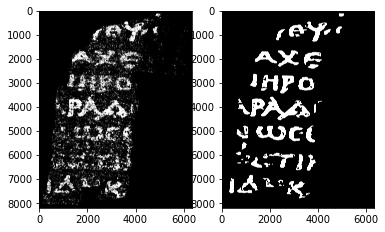

Sørensen–Dice coefficient for evaluation data: 0.49527


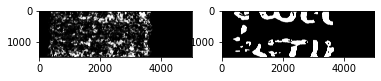

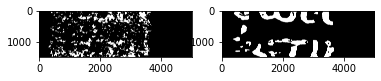

Complete time taken: 465.8369 seconds
----------------------------------------------------------------------------------------------------
Testing out rectangle: (200, 6500, 5000, 1500)
Train elements: 24097212 | Evaluation elements: 4842298
Length of train_dataloader: 753038 batches of size 32
Length of eval_dataloader: 151322 batches of size 32
xb.shape: torch.Size([32, 1, 10, 64, 64]) | yb.shape: torch.Size([32, 1])


  0%|          | 1/30000 [00:04<41:10:54,  4.94s/it]

Train Loss: 0.70905 | Test Loss: 0.71171 | Time taken: 1.359


 10%|█         | 3056/30000 [00:19<10:44, 41.79it/s]

Train Loss: 0.42532 | Test Loss: 0.43314 | Time taken: 1.351


 20%|██        | 6042/30000 [00:32<09:50, 40.61it/s]

Train Loss: 0.39559 | Test Loss: 0.43415 | Time taken: 1.374


 30%|███       | 9040/30000 [00:46<08:34, 40.75it/s]

Train Loss: 0.36184 | Test Loss: 0.4805 | Time taken: 1.365


 40%|████      | 12042/30000 [01:00<07:09, 41.83it/s]

Train Loss: 0.376 | Test Loss: 0.61372 | Time taken: 1.354


 50%|█████     | 15044/30000 [01:14<05:52, 42.44it/s]

Train Loss: 0.37748 | Test Loss: 0.59007 | Time taken: 1.352


 60%|██████    | 18051/30000 [01:27<04:46, 41.78it/s]

Train Loss: 0.33455 | Test Loss: 0.5478 | Time taken: 1.349


 70%|███████   | 21053/30000 [01:41<03:35, 41.43it/s]

Train Loss: 0.3338 | Test Loss: 0.53953 | Time taken: 1.370


 80%|████████  | 24040/30000 [01:55<02:21, 42.04it/s]

Train Loss: 0.30672 | Test Loss: 0.75119 | Time taken: 1.356


 90%|█████████ | 27041/30000 [02:08<01:10, 42.05it/s]

Train Loss: 0.2796 | Test Loss: 0.80739 | Time taken: 1.342


100%|██████████| 30000/30000 [02:19<00:00, 215.10it/s]


Apollo train loss: 0.23497
Apollo test loss: 0.86171


100%|██████████| 18583/18583 [00:42<00:00, 437.78it/s]


Sørensen–Dice coefficient for full data: 0.67792


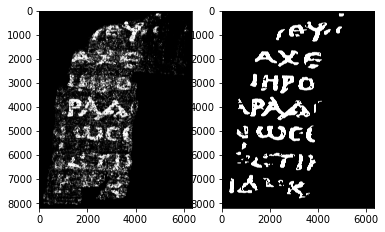

Sørensen–Dice coefficient for evaluation data: 0.38838


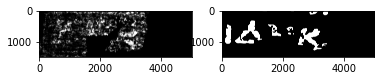

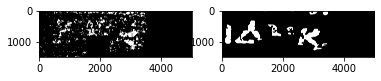

  0%|          | 20/30000 [00:05<1:32:01,  5.43it/s]

Train Loss: 0.67847 | Test Loss: 0.67596 | Time taken: 1.397


 10%|█         | 3027/30000 [00:25<15:39, 28.72it/s]

Train Loss: 0.29914 | Test Loss: 0.66577 | Time taken: 1.248


 20%|██        | 6035/30000 [00:44<13:51, 28.84it/s]

Train Loss: 0.28325 | Test Loss: 0.54153 | Time taken: 1.252


 30%|███       | 9027/30000 [01:04<11:30, 30.39it/s]

Train Loss: 0.30227 | Test Loss: 0.77727 | Time taken: 1.234


 40%|████      | 12023/30000 [01:23<10:19, 29.02it/s]

Train Loss: 0.27225 | Test Loss: 0.57312 | Time taken: 1.236


 50%|█████     | 15036/30000 [01:43<08:34, 29.11it/s]

Train Loss: 0.24779 | Test Loss: 0.63801 | Time taken: 1.246


 60%|██████    | 18021/30000 [02:02<06:48, 29.35it/s]

Train Loss: 0.23715 | Test Loss: 0.65005 | Time taken: 1.250


 70%|███████   | 21025/30000 [02:21<05:10, 28.92it/s]

Train Loss: 0.25523 | Test Loss: 0.67597 | Time taken: 1.243


 80%|████████  | 24021/30000 [02:41<03:27, 28.77it/s]

Train Loss: 0.22146 | Test Loss: 0.85663 | Time taken: 1.260


 90%|█████████ | 27024/30000 [03:00<01:40, 29.48it/s]

Train Loss: 0.20222 | Test Loss: 0.83779 | Time taken: 1.262


100%|██████████| 30000/30000 [03:17<00:00, 151.66it/s]


Hercules train loss: 0.20072
Hercules test loss: 0.91925


100%|██████████| 18583/18583 [00:57<00:00, 322.96it/s]


Sørensen–Dice coefficient for full data: 0.72388


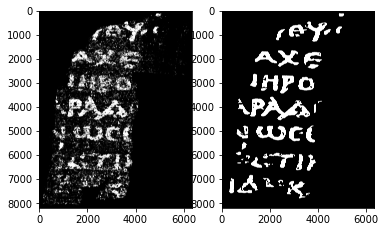

Sørensen–Dice coefficient for evaluation data: 0.41012


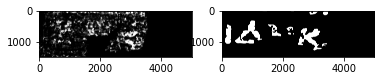

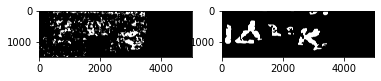

Complete time taken: 463.7230 seconds


In [20]:
for evaluation_rectangle in rectangles:
  print("-"*100)
  print(f"Testing out rectangle: {evaluation_rectangle}")
  t1 = time.time()
  apollo = Apollo().to(device)

  train_dataloader, eval_dataloader = create_train_eval_dataloaders(image_stack, mask, label, evaluation_rectangle, dist_from_centre, batch_size)
  train_loop(apollo, training_steps, eval_interval, train_dataloader, eval_dataloader, learning_rate=learning_rate)
  print(f"Apollo train loss: {evaluate(apollo, train_dataloader, eval_iterations = 200)['loss']}")
  print(f"Apollo test loss: {evaluate(apollo, eval_dataloader, eval_iterations = 200)['loss']}")
  display_predictions(apollo, evaluation_rectangle, only_rectangle=False, threshold = 0.4, stride = 7)

  hercules = HerculesModel(apollo).to(device)
  train_loop(hercules, training_steps, eval_interval, train_dataloader, eval_dataloader, learning_rate=learning_rate)
  print(f"Hercules train loss: {evaluate(hercules, train_dataloader, eval_iterations = 200)['loss']}")
  print(f"Hercules test loss: {evaluate(hercules, eval_dataloader, eval_iterations = 200)['loss']}")

  display_predictions(hercules, evaluation_rectangle, only_rectangle=False, threshold = 0.4, stride = 7)
  print(f"Complete time taken: {time.time()-t1:.4f} seconds")

  

----------------------------------------------------------------------------------------------------
Testing out rectangle: (200, 500, 5000, 1500)
Train elements: 23903948 | Evaluation elements: 4989667
Length of train_dataloader: 746999 batches of size 32
Length of eval_dataloader: 155928 batches of size 32
xb.shape: torch.Size([32, 1, 10, 64, 64]) | yb.shape: torch.Size([32, 1])


  0%|          | 28/30000 [00:11<2:30:55,  3.31it/s]

Train Loss: 0.67258 | Test Loss: 0.67865 | Time taken: 1.447


 10%|█         | 3029/30000 [00:25<10:34, 42.53it/s]

Train Loss: 0.49981 | Test Loss: 0.58926 | Time taken: 1.361


 20%|██        | 6047/30000 [00:38<09:07, 43.74it/s]

Train Loss: 0.41718 | Test Loss: 0.4637 | Time taken: 1.280


 30%|███       | 9046/30000 [00:52<07:38, 45.70it/s]

Train Loss: 0.46168 | Test Loss: 0.8152 | Time taken: 1.265


 40%|████      | 12033/30000 [01:05<06:58, 42.94it/s]

Train Loss: 0.40119 | Test Loss: 0.42605 | Time taken: 1.363


 50%|█████     | 15052/30000 [01:18<05:30, 45.29it/s]

Train Loss: 0.386 | Test Loss: 0.42217 | Time taken: 1.264


 60%|██████    | 18044/30000 [01:32<04:35, 43.35it/s]

Train Loss: 0.37914 | Test Loss: 0.45045 | Time taken: 1.326


 70%|███████   | 21052/30000 [01:45<03:20, 44.59it/s]

Train Loss: 0.33791 | Test Loss: 0.33088 | Time taken: 1.303


 80%|████████  | 24040/30000 [01:58<02:11, 45.16it/s]

Train Loss: 0.28017 | Test Loss: 0.39763 | Time taken: 1.276


 90%|█████████ | 27030/30000 [02:11<01:06, 44.72it/s]

Train Loss: 0.27201 | Test Loss: 0.41746 | Time taken: 1.280


100%|██████████| 30000/30000 [02:22<00:00, 210.42it/s]


Apollo train loss: 0.24446
Apollo test loss: 0.26103


100%|██████████| 18583/18583 [00:41<00:00, 451.73it/s]


Sørensen–Dice coefficient for full data: 0.65391


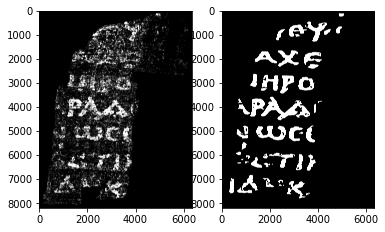

Sørensen–Dice coefficient for evaluation data: 0.48055


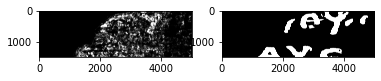

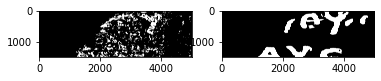

  0%|          | 19/30000 [00:04<1:32:10,  5.42it/s]

Train Loss: 0.66264 | Test Loss: 0.67089 | Time taken: 1.314


 10%|█         | 3030/30000 [00:24<16:12, 27.74it/s]

Train Loss: 0.28125 | Test Loss: 0.5118 | Time taken: 1.327


 20%|██        | 6036/30000 [00:43<13:53, 28.77it/s]

Train Loss: 0.28025 | Test Loss: 0.39357 | Time taken: 1.321


 30%|███       | 9036/30000 [01:03<12:30, 27.93it/s]

Train Loss: 0.31292 | Test Loss: 0.61686 | Time taken: 1.345


 40%|████      | 12020/30000 [01:22<11:14, 26.64it/s]

Train Loss: 0.27232 | Test Loss: 0.38995 | Time taken: 1.425


 50%|█████     | 15032/30000 [01:41<09:13, 27.06it/s]

Train Loss: 0.28945 | Test Loss: 0.45457 | Time taken: 1.423


 60%|██████    | 18037/30000 [02:01<06:59, 28.52it/s]

Train Loss: 0.27454 | Test Loss: 0.55584 | Time taken: 1.337


 70%|███████   | 21028/30000 [02:20<05:14, 28.52it/s]

Train Loss: 0.24319 | Test Loss: 0.29696 | Time taken: 1.338


 80%|████████  | 24024/30000 [02:39<03:25, 29.10it/s]

Train Loss: 0.21473 | Test Loss: 0.39657 | Time taken: 1.305


 90%|█████████ | 27032/30000 [02:58<01:43, 28.73it/s]

Train Loss: 0.20479 | Test Loss: 0.53927 | Time taken: 1.303


100%|██████████| 30000/30000 [03:14<00:00, 153.96it/s]


Hercules train loss: 0.19766
Hercules test loss: 0.30072


100%|██████████| 18583/18583 [00:55<00:00, 332.02it/s]


Sørensen–Dice coefficient for full data: 0.7074


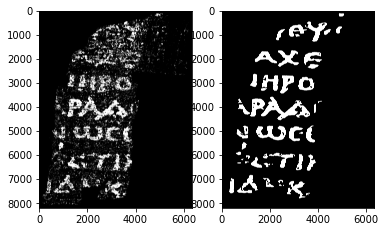

Sørensen–Dice coefficient for evaluation data: 0.46148


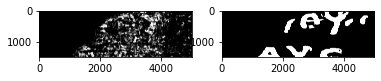

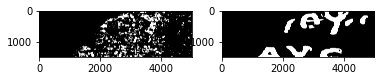

  0%|          | 16/30000 [00:04<1:49:15,  4.57it/s]

Train Loss: 0.20377 | Test Loss: 0.38215 | Time taken: 1.329


 10%|█         | 3028/30000 [00:28<19:32, 23.01it/s]

Train Loss: 0.28296 | Test Loss: 0.58983 | Time taken: 1.337


 20%|██        | 6026/30000 [00:51<17:52, 22.36it/s]

Train Loss: 0.31035 | Test Loss: 0.34479 | Time taken: 1.353


 30%|███       | 9027/30000 [01:14<15:32, 22.50it/s]

Train Loss: 0.24507 | Test Loss: 0.35801 | Time taken: 1.346


 40%|████      | 12024/30000 [01:36<12:58, 23.10it/s]

Train Loss: 0.27288 | Test Loss: 0.52577 | Time taken: 1.327


 50%|█████     | 15027/30000 [01:59<10:56, 22.82it/s]

Train Loss: 0.17798 | Test Loss: 0.4242 | Time taken: 1.323


 60%|██████    | 18027/30000 [02:22<08:51, 22.54it/s]

Train Loss: 0.21231 | Test Loss: 0.4584 | Time taken: 1.342


 70%|███████   | 21026/30000 [02:45<06:36, 22.65it/s]

Train Loss: 0.17935 | Test Loss: 0.37952 | Time taken: 1.341


 80%|████████  | 24026/30000 [03:08<04:21, 22.86it/s]

Train Loss: 0.1505 | Test Loss: 0.39704 | Time taken: 1.319


 90%|█████████ | 27027/30000 [03:31<02:09, 23.05it/s]

Train Loss: 0.10798 | Test Loss: 0.47264 | Time taken: 1.334


100%|██████████| 30000/30000 [03:51<00:00, 129.52it/s]


Hercules train loss: 0.10014
Hercules test loss: 0.35703


100%|██████████| 18583/18583 [00:55<00:00, 332.04it/s]


Sørensen–Dice coefficient for full data: 0.80446


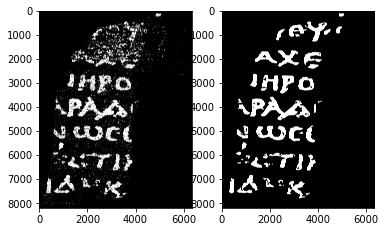

Sørensen–Dice coefficient for evaluation data: 0.45464


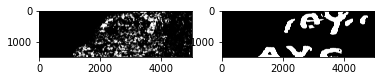

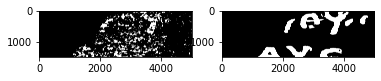

Complete time taken: 760.2664 seconds


In [21]:
print("-"*100)
evaluation_rectangle = (200, 500, 5000, 1500)
print(f"Testing out rectangle: {evaluation_rectangle}")
t1 = time.time()
apollo = Apollo().to(device)

train_dataloader, eval_dataloader = create_train_eval_dataloaders(image_stack, mask, label, evaluation_rectangle, dist_from_centre, batch_size)
train_loop(apollo, training_steps, eval_interval, train_dataloader, eval_dataloader, learning_rate=learning_rate)
print(f"Apollo train loss: {evaluate(apollo, train_dataloader, eval_iterations = 200)['loss']}")
print(f"Apollo test loss: {evaluate(apollo, eval_dataloader, eval_iterations = 200)['loss']}")
display_predictions(apollo, evaluation_rectangle, only_rectangle=False, threshold = 0.4, stride = 7)

hercules = HerculesModel(apollo).to(device)
train_loop(hercules, training_steps, eval_interval, train_dataloader, eval_dataloader, learning_rate=learning_rate)
print(f"Hercules train loss: {evaluate(hercules, train_dataloader, eval_iterations = 200)['loss']}")
print(f"Hercules test loss: {evaluate(hercules, eval_dataloader, eval_iterations = 200)['loss']}")
display_predictions(hercules, evaluation_rectangle, only_rectangle=False, threshold = 0.4, stride = 7)

for param in hercules.layers.apollo_conv3d.parameters():
    param.requires_grad = True

train_loop(hercules, training_steps, eval_interval, train_dataloader, eval_dataloader, learning_rate=learning_rate)
print(f"Hercules train loss: {evaluate(hercules, train_dataloader, eval_iterations = 200)['loss']}")
print(f"Hercules test loss: {evaluate(hercules, eval_dataloader, eval_iterations = 200)['loss']}")
display_predictions(hercules, evaluation_rectangle, only_rectangle=False, threshold = 0.4, stride = 7)

print(f"Complete time taken: {time.time()-t1:.4f} seconds")